<a href="https://colab.research.google.com/github/RiverGumSecurity/AILabs/blob/main/examples/PandasExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning with Phishing Email Data

This notebook explores core concepts and and provides examples of supervised machine learning. We will use phishing emails as a dataset and compare statistcal learning methods, such as Logistic Regression, Decision Tree, Naive Bayes and more.

The phishing vs. not-phishing, or spam vs. ham, is a binary classification problem. This is where we have two classes of data and we want to categorize each data point into one of two distinct classes based on their features.  The data set we will work with is pre-labeled into each category so that we can train and test our machine learning models, otherwise we would need to do this step ourselves (which would be time consuming).

The overall process is to:

- Obtain data and label each category (this is already done)

- Import data into Pandas dataframe to facilitate data cleaning, processing, and feature creation

- Create features from the data by converting text to vectors of numbers and spliting the data into training and test sets

- Fit the data to a model to test, this where the machine learns the optimal algorithm to classify the data as one category or the other

- Evaluate and interpret the model results


Once we have selected the best performing model, the next step would be to implement it. We will not be performing that step, that's a whole new set of software design problems outside the scope of the course.  But we can get a good grasp the heart of the solutions in use today by evaluating ML models.

What ML models are good choices for this type binary classification problem?  There are quite a few each with their own pros and cons, here are some examples:

- **Logistic Regression:** A linear model for binary classification that estimates the probability that a given input belongs to a certain class

- **Support Vector Machine (SVM):** Finds the hyperplane that best separates the two classes by maximizing the margin between them

- **Decision Tree:** Flowchart-like structure where each internal node represents a decision based on a feature, each branch represents the outcome of the decision, and each leaf node represents a class label

- **Random Forrest:** Ensemble method that builds multiple decision trees (usually trained with the "bagging" method) and merges their results to improve accuracy and control overfitting

- **Naive Bayes:** Based on Bayes' theorem with the assumption of independence between predictors

- **Gradient Boosting Machine (GMB):** - Ensemble technique that builds models sequentially each one correcting the errors of the previous ones



In [1]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import datetime
import os 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import warnings

In [2]:
# Set numpy random seed for reproducible numbers
np.random.seed(42)

In [3]:
# Detect GPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 285397105788507206
xla_global_id: -1
]


## Dataset

The dataset that will be used to train and test the different models was from https://www.kaggle.com/datasets/subhajournal/phishingemails.  It was pre-labeled as "Safe Email" or "Phishing Email".  The data will be cleaned and prepared for training machine learning models with Pandas.


In [4]:
# Read in the data into a Pandas dataframe
#df = pd.read_csv('https://raw.githubusercontent.com/RiverGumSecurity/AILabs/main/datasets/Phishing_Email.csv')

df = pd.read_csv('../datasets/Phishing_Email.csv')
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [5]:
# Print information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [6]:
# Find null values in the data - these can cause issues for computation later in the notebook
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [7]:
# Drop null values in place, drop Unamed:0 column, drop duplicates
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [8]:
# Show the shape of the data
df.shape

(17538, 2)

In [9]:
# Display cleaned dataframe
df.head(10)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,re : coastal deal - with exxon participation u...,Safe Email


In [10]:
# Display the count of Email types, a Safe Email or a Phishing Email
df['Email Type'].value_counts()

Email Type
Safe Email        10980
Phishing Email     6558
Name: count, dtype: int64

<Axes: xlabel='Email Type'>

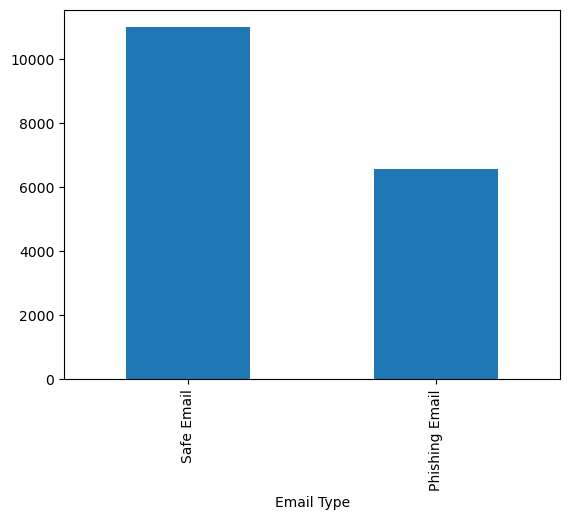

In [11]:
# Plot counts of Safe Email vs Phishing Email
df['Email Type'].value_counts().plot(kind='bar')

Now we need to further process and clean the data. This is a binary classification problem, and we need to assign a label (a 1 or a 0) to the email categories. Then we will remove URLS and non word characters from the emails - we are interested in the similarities of the text itself.  Then we lowercase all of the characters, convert all multiple whitespace characters to single whitespace, and remove any trailing whitespaces.

In [12]:
# Label Email Type
lbl = LabelEncoder()
df['Email Type'] = lbl.fit_transform(df['Email Type'])

In [13]:
# Function to preprocess text.
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Email Text']=df['Email Text'].apply(preprocess_text)

In [14]:
df.head(10)

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0
5,global risk management operations sally congra...,1
6,on sun aug 11 2002 at 111747am 0100 wintermute...,1
7,entourage stockmogul newsletter ralph velez ge...,0
8,we owe you lots of money dear applicant after ...,0
9,re coastal deal with exxon participation under...,1


## Convert Text to Numerical Vectory (create features)

Now we convert the text into a TF-IDF (Term Frequencey Inverse Document Frequency) matrix. This a statistical measure that evaluates how relevant a word is to a document in a collection of documents. It combines two metrics: the number of times a word appears in a document (term frequency) and the inverse document frequency of the word across the entire set of documents where each email is a document.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

The Email Type columns is then converted into a numpy array.  Data from both calculations is stored in a class object.

In [15]:
# Convert email text to an array of vectors, removing stop words
tf = TfidfVectorizer(stop_words='english',max_features=10000) #dimension reduction
feature_x = tf.fit_transform(df['Email Text']).toarray()

# convert the label into numpy array
y_tf = np.array(df['Email Type']) 

In [16]:
print(type(tf))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


## Split Data into Training and Validation Test Sets

In data science and traning and testing machine learning models, it is common practice to split the data into traning and validation splits.  Usually this is an 80/20 split where 80% of the data is used for training the model, and 20% is used for validation. The validation process is used to measure the accuracy of the model using various statistical measurements.

In [17]:
#split dataset into training and testing data groups, 80 percent training, 20 percent testing
X_tr,X_tst,y_tr,y_tst = train_test_split(feature_x,y_tf,test_size=0.2,random_state=0)

## Logistic Regression

Now that we have split our data into traning and validation sets, we are ready for our first machine learning model that will be able to tell if an email is phishing or not based on the text of the email.  The first model we will explore is Logistic Regression.

Logistic regression is a statistical method used for binary classification, where the goal is to predict the probability that a given input belongs to one of two categories. It models the relationship between a dependent binary variable and one or more independent variables using the logistic function, producing an output between 0 and 1. This output can then be thresholded to classify the input into one of the two categories.

A [**good explanation**](https://www.youtube.com/watch?v=yIYKR4sgzI8) of how this works can be found from the good folks at StatQuest on their YouTube channel.

We will use the SciKit Learn implmentation of the [**Logistic Regression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) algorithm.




## Run Logistic Regression Model

In [18]:
# instantiate Logistic Regression class and fit the model to the data
lg = LogisticRegression()
lg.fit(X_tr,y_tr)

# predict whether class 0 (phishing) or class 1 (not phishing)
pred_lg = lg.predict(X_tst)

## Interpret Logistic Regression Model 

A common way to score and interpret the results of a training and testing run of a machine learning model is with a classification report comparing the predictect results with the validation set (that was not used for training).

In [19]:
# Caclulate the accuracy and the f1 score of the Logistic Regression model.
# store in variables for later
lr_accu = accuracy_score(y_tst,pred_lg)*100
lr_f1 = f1_score(y_tst,pred_lg)*100

#these two lines can probably be deleted
#print("The Logistic Regression model accuracy score was " + str(lr_accu) + "\n")
#print("The Logistic Regression model F1 score was " + str(lr_f1) + "\n")

print(classification_report(y_tst,pred_lg))



              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1351
           1       0.98      0.99      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



So how do we read and interpret this table?

**Precision:** The ratio of correctly predicted positive observations to the total predicted positives. It answers the question: "Of all the instances that the classifier labeled as positive, how many are actually positive?"

**Recall (Sensitivity):** The ratio of correctly predicted positive observations to all observations in the actual class. It answers the question: "Of all the actual positive instances, how many were correctly predicted?"

**F1-Score:** The harmonic mean of precision and recall. It is a better measure than accuracy for imbalanced datasets.

**Support:** The number of actual occurrences of the class in the dataset.

**Accuracy:** The ratio of correctly predicted instances to the total instances. For this model, the accuracy is 0.98 (98%), meaning 98% of the predictions are correct.

**Macro Average:** The average of precision, recall, and F1-score calculated for each class independently and then averaged. This metric treats all classes equally.

**Weighted Average:** The average of precision, recall, and F1-score, weighted by the number of instances in each class (support). This metric is more representative when there is a class imbalance.

Another way tp evaluate a classification model is a confusion matrix.  This is a table showing the counts of true positive, true negative, false positive, and false negative predictions. Each row of the matrix represents the actual class, while each column represents the predicted class, allowing for a clear visualization of where the model is making correct and incorrect predictions. This helps in understanding the model's accuracy, precision, recall, and other performance metrics.

**Confusion Matrix for the Logistic Regression Model**

- upper left - number of emails predicted to be phishing and are actually phishing (True Positive)

- upper right - number of emails predicted as not phishing that are actually phishing (False Positive)

- lower left - number emails predicted to be phishing that are actually not phishing (False Negative)

- lower right - number of emails predicted ast not phishing that are actually not phishing (True Negative)

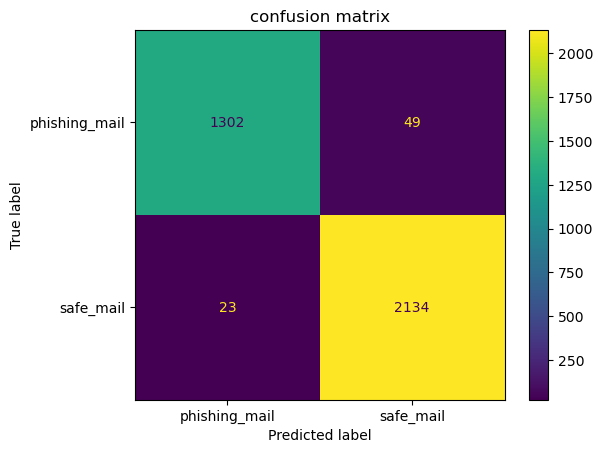

In [20]:
clf_lg = confusion_matrix(y_tst,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

# Decision Tree

The decision tree machine learning algorithm can be used for classification and regression tasks, we will use the [**Scikit-Learn Decision Tree**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) module. It works by splitting the data into subsets based on the value of input features, creating a tree-like model of decisions. Each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label or a continuous value.


In [21]:
# instantiate DecisionTreeClassifier class and fit the model to the data
dt = DecisionTreeClassifier()
dt.fit(X_tr,y_tr)

# predict whether class 0 (phishing) or class 1 (not phishing)
pred_dt = dt.predict(X_tst)

In [22]:
# Caclulate the accuracy and the f1 score of the Decision Tree model.
# store in variables for later
dt_accu = accuracy_score(y_tst,pred_dt)*100
dt_f1 = f1_score(y_tst,pred_dt)*100


print(classification_report(y_tst,pred_dt))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1351
           1       0.95      0.94      0.94      2157

    accuracy                           0.93      3508
   macro avg       0.93      0.93      0.93      3508
weighted avg       0.93      0.93      0.93      3508



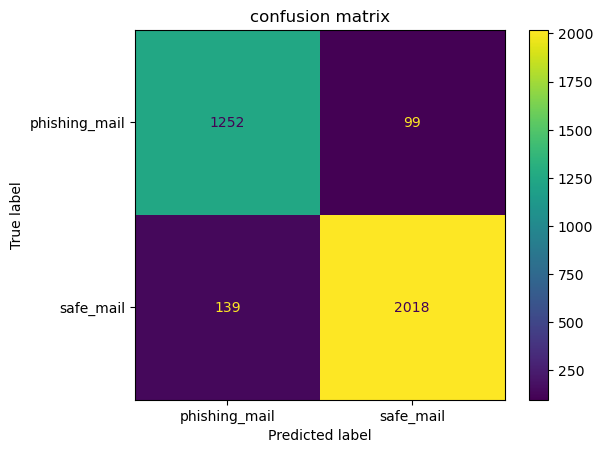

In [23]:
clf_dt = confusion_matrix(y_tst,pred_dt)
cx_ = ConfusionMatrixDisplay(clf_dt,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## Random Forrest

[**Random forest**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is an ensemble machine learning technique that combines multiple decision trees to improve predictive performance. It builds numerous decision trees during training and merges their outputs to make a final prediction, reducing overfitting and increasing accuracy. This method enhances robustness and generalization by averaging the results from individual trees, which are trained on different subsets of the data.


In [24]:
rfc = RandomForestClassifier()
rfc.fit(X_tr,y_tr)

pred_rfc = rfc.predict(X_tst)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1351
           1       0.99      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



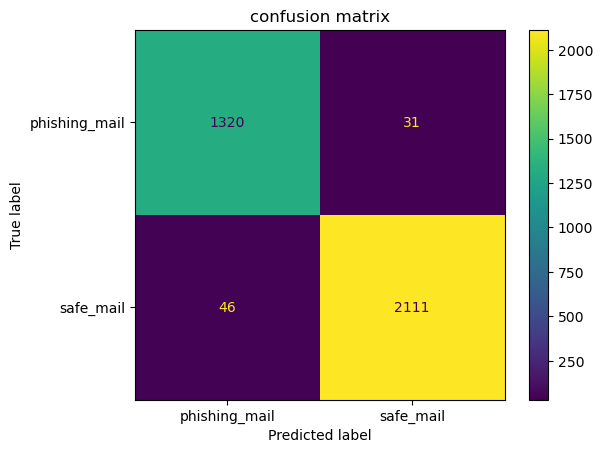

In [25]:
rfc_accu = accuracy_score(y_tst,pred_rfc)*100
rfc_f1 = f1_score(y_tst,pred_rfc)*100


print(classification_report(y_tst,pred_rfc))

clf_rfc = confusion_matrix(y_tst,pred_rfc)
cx_ = ConfusionMatrixDisplay(clf_rfc,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

### Support Vector Machine

A [**Support Vector Machine (SVM)**](https://scikit-learn.org/stable/modules/svm.html#classification) is a supervised learning algorithm used for classification tasks that finds the optimal hyperplane to separate data points of different classes. By maximizing the margin between the closest points of the classes (support vectors), SVM ensures the best separation. It can handle non-linear classification through the use of kernel functions, which transform the data into higher dimensions where a linear separator can be found.

In [26]:
svm = LinearSVC()
svm.fit(X_tr,y_tr)

pred_svm = svm.predict(X_tst)

/opt/miniconda3/envs/ai/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [27]:
svm_accu = accuracy_score(y_tst,pred_svm)*100
svm_f1 = f1_score(y_tst,pred_svm)*100

print(classification_report(y_tst,pred_svm))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



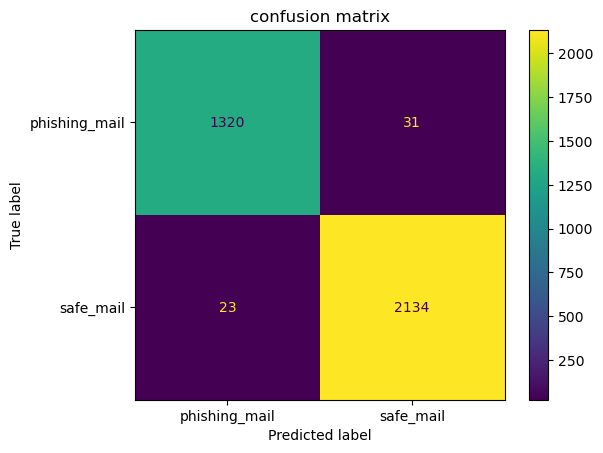

In [28]:
clf_svm = confusion_matrix(y_tst,pred_svm)
cx_ = ConfusionMatrixDisplay(clf_svm,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## Multinomial Naive Bayes 

[**Multinomial Naive Bayes**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) is a probabilistic machine learning algorithm used for classification tasks, particularly effective for text classification such as spam detection and document categorization. It assumes that features follow a multinomial distribution and calculates the probability of each class based on the frequency of features (e.g., words) in the training data. Despite its simplicity, it often performs well with large, sparse datasets and is known for its efficiency and scalability.

In [29]:
nb = MultinomialNB()
nb.fit(X_tr,y_tr)

pred_nb = nb.predict(X_tst)

In [30]:


nb_accu = accuracy_score(y_tst,pred_nb)*100
nb_f1 = f1_score(y_tst,pred_nb)*100

print(classification_report(y_tst,pred_nb))



              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.98      0.98      0.98      3508



Confusion Matrix
upper left - number of emails predicted to be phishing and are actually phishing (True Positive)
upper right - number of emails predicted as not phishing that are actually phishing (False Positive)
lower left - number emails predicted to be phishing that are actually not phishing (False Negative)
lower right - number of emails predicted ast not phishing that are actually not phishing (True Negative)

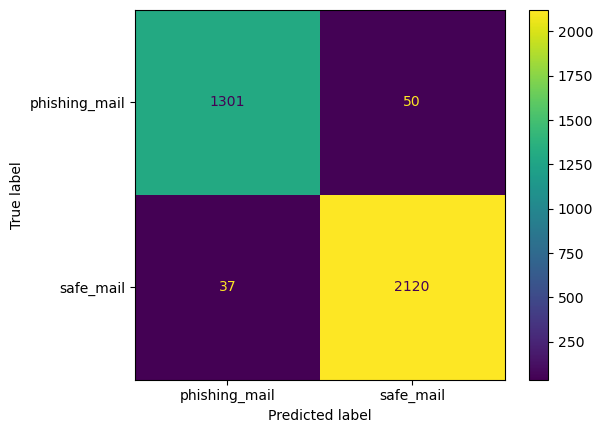

In [31]:
clf_nb = confusion_matrix(y_tst,pred_nb)
cx_ = ConfusionMatrixDisplay(clf_nb,display_labels=['phishing_mail','safe_mail']).plot()
plt.show()

## Gradient Boosting Machine 

A [**Gradient Boosting Machine (GBM)**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) is an ensemble learning technique that builds models sequentially, where each new model corrects the errors of the previous ones. It works by combining weak learners, typically decision trees, in a stage-wise fashion to minimize a loss function, enhancing the overall predictive accuracy. GBM is known for its high performance in various machine learning tasks, but it can be computationally intensive and prone to overfitting if not properly tuned.

In [39]:
gbc = GradientBoostingClassifier()
gbc.fit(X_tr,y_tr)

pred_gbc = gbc.predict(X_tst)

In [38]:
gbc_accu = accuracy_score(y_tst,pred_gbc)*100
gbc_f1 = f1_score(y_tst,pred_gbc)*100

print(classification_report(y_tst,pred_gbc))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1351
           1       0.93      0.98      0.96      2157

    accuracy                           0.95      3508
   macro avg       0.95      0.94      0.94      3508
weighted avg       0.95      0.95      0.95      3508



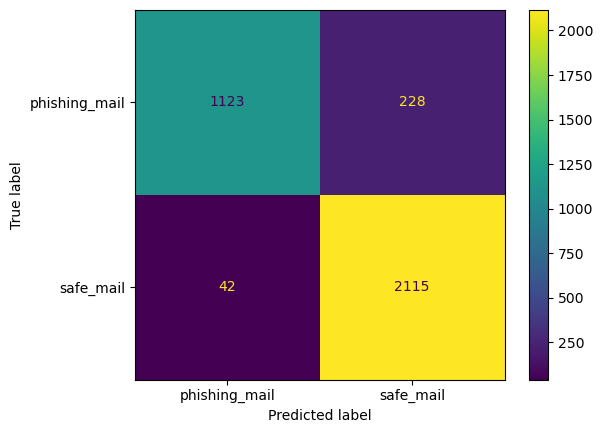

In [34]:
clf_gbc = confusion_matrix(y_tst,pred_gbc)
cx_ = ConfusionMatrixDisplay(clf_gbc,display_labels=['phishing_mail','safe_mail']).plot()
plt.show()

# Comparisons



In [35]:


accu_values = [lr_accu,dt_accu,rfc_accu,svm_accu,nb_accu,gbc_accu]
row_labels = ["Logistic Regression", "Decision Tree", "Random Forest","Support Vector Machine","Naive Bayes", "Gradient Boosting Machine"]
comp_df = pd.DataFrame(accu_values, columns=["accuracy"], index=row_labels)
print(comp_df)

                            accuracy
Logistic Regression        97.947548
Decision Tree              93.215507
Random Forest              97.805017
Support Vector Machine     98.460661
Naive Bayes                97.519954
Gradient Boosting Machine  92.303307


In [36]:
print(svm_accu)

98.46066134549602
